In [9]:
 ##### import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (20,12)

from google.cloud import bigquery
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from scipy import stats
from statsmodels.tsa.api import VAR
from statsmodels.tools.eval_measures import rmse, aic
import datetime
import re
import pandas as pd

In [5]:
client = bigquery.Client()
conv_df = client.query("""
SELECT * FROM conversions
""").to_dataframe()

conv_df['date'] = pd.to_datetime(conv_df['date'])

inq_df = client.query("""
SELECT * FROM inquiries
""").to_dataframe()

inq_df['date'] = pd.to_datetime(inq_df['date'])

In [10]:
#Monthly
#urate_raw = pd.read_csv('https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=UNRATE&scale=left&cosd=1948-01-01&coed=2021-05-01&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Monthly&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-06-25&revision_date=2021-06-25&nd=1948-01-01')

#Weekly
end_date = datetime.date.isoformat(datetime.date.today())
#urate_raw = pd.read_csv("https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=ICSA&scale=left&cosd=1967-01-07&coed=2021-06-26&line_color=%234572a7&link_values=false&line_style=solid&mark_type=none&mw=3&lw=2&ost=-99999&oet=99999&mma=0&fml=a&fq=Weekly%2C%20Ending%20Saturday&fam=avg&fgst=lin&fgsnd=2020-02-01&line_index=1&transformation=lin&vintage_date=2021-07-12&revision_date=2021-07-12&nd=1967-01-07")
urate_raw = pd.read_csv(f"https://fred.stlouisfed.org/graph/fredgraph.csv?bgcolor=%23e1e9f0&chart_type=line&drp=0&fo=open%20sans&graph_bgcolor=%23ffffff&height=450&mode=fred&recession_bars=on&txtcolor=%23444444&ts=12&tts=12&width=1168&nt=0&thu=0&trc=0&show_legend=yes&show_axis_titles=yes&show_tooltip=yes&id=ICSA,ICNSA&scale=left,left&cosd=1967-01-07,1967-01-07&coed=2021-07-03,2021-07-03&line_color=%234572a7,%23aa4643&link_values=false,false&line_style=solid,solid&mark_type=none,none&mw=3,3&lw=2,2&ost=-99999,-99999&oet=99999,99999&mma=0,0&fml=a,a&fq=Weekly%2C%20Ending%20Saturday,Weekly%2C%20Ending%20Saturday&fam=avg,avg&fgst=lin,lin&fgsnd=2020-02-01,2020-02-01&line_index=1,2&transformation=lin,lin&vintage_date={end_date},{end_date}&revision_date={end_date},{end_date}&nd=1967-01-07,1967-01-07")

In [12]:
urate_raw.drop(columns='ICSA', inplace = True)
urate = urate_raw[urate_raw.DATE >= '2018-01-01']
urate['DATE'] = pd.to_datetime(urate.DATE)
urate.rename(columns={'ICNSA':'UNRATE'}, inplace = True)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:5047: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
df = urate.merge(conv_df, how='left', left_on='DATE',right_on='date').drop(columns='date').replace(np.nan, 0)#.set_index('DATE')
df = df.merge(inq_df, how='left', left_on='DATE',right_on='date').drop(columns='date').replace(np.nan, 0).set_index('DATE')


In [15]:
def var_craziness(matrix,lags,forecast_prds,causing, caused):
    #model = VAR(df[['positive','UNRATE','conv']])
    model = VAR(matrix)
                  
    fitted_model = model.fit(lags)

    fitted_model.plot()

    fitted_model.plot_acorr()

    fitted_model.plot_forecast(forecast_prds)
    fitted_model.fevd(10).plot()

    from statsmodels.tsa.vector_ar.irf import IRAnalysis
    irf_results = IRAnalysis(fitted_model)
    irf_results.plot()
    irf_results.plot_cum_effects()
    
    
    plt.legend(loc='best')
    plt.show()
    
    print('\nGranger Causality:')
    for c in caused:
        print(fitted_model.test_causality(causing=causing,caused=c, kind='f').summary())
    
    from statsmodels.stats.stattools import durbin_watson
    out = durbin_watson(fitted_model.resid)

    print('\nDurban Watson Test for Serial Correlation (2 is mid-point):')
    for col, val in zip(matrix, out):
        print(col, ':', round(val, 2))
        
    #grangercausalitytests(matrix,5)
    
    return(fitted_model)

    #Results are 0-4.  The closer to 2, the less Serial Corr.  Close to 0 is positive, close to 4 is neg.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SAT will be used.
  self._init_dates(dates, freq)


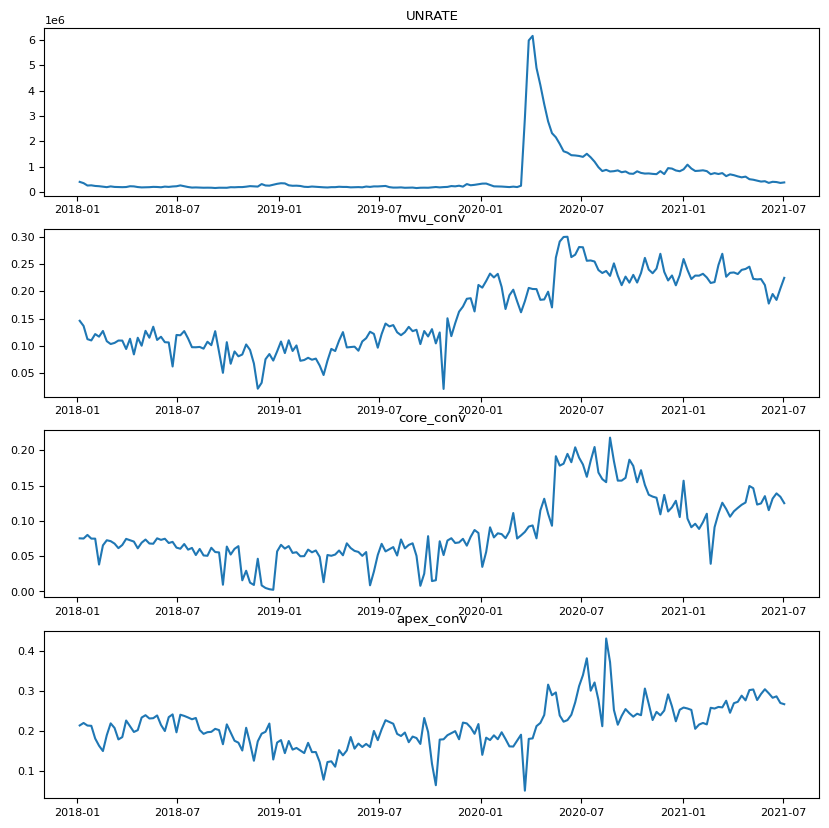

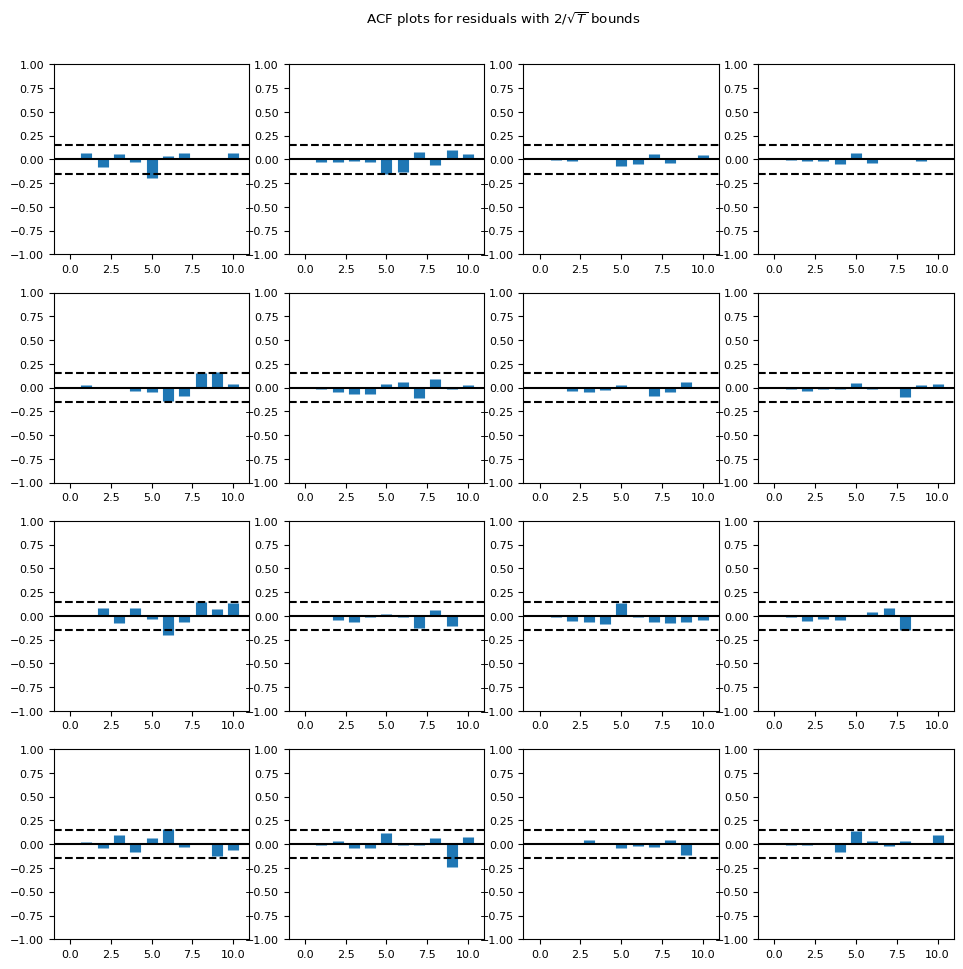

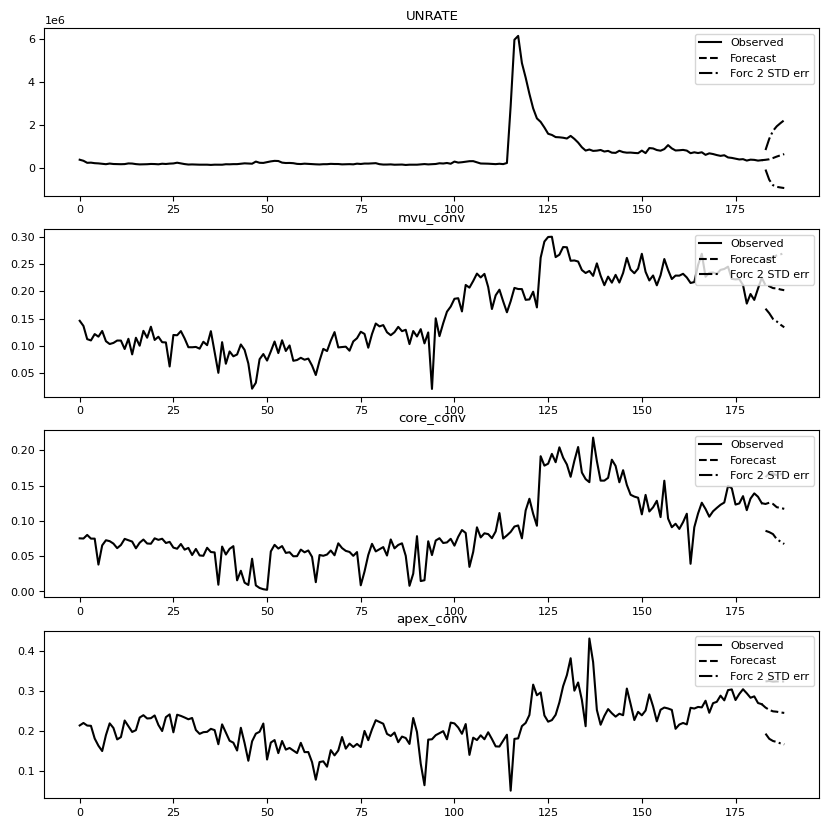

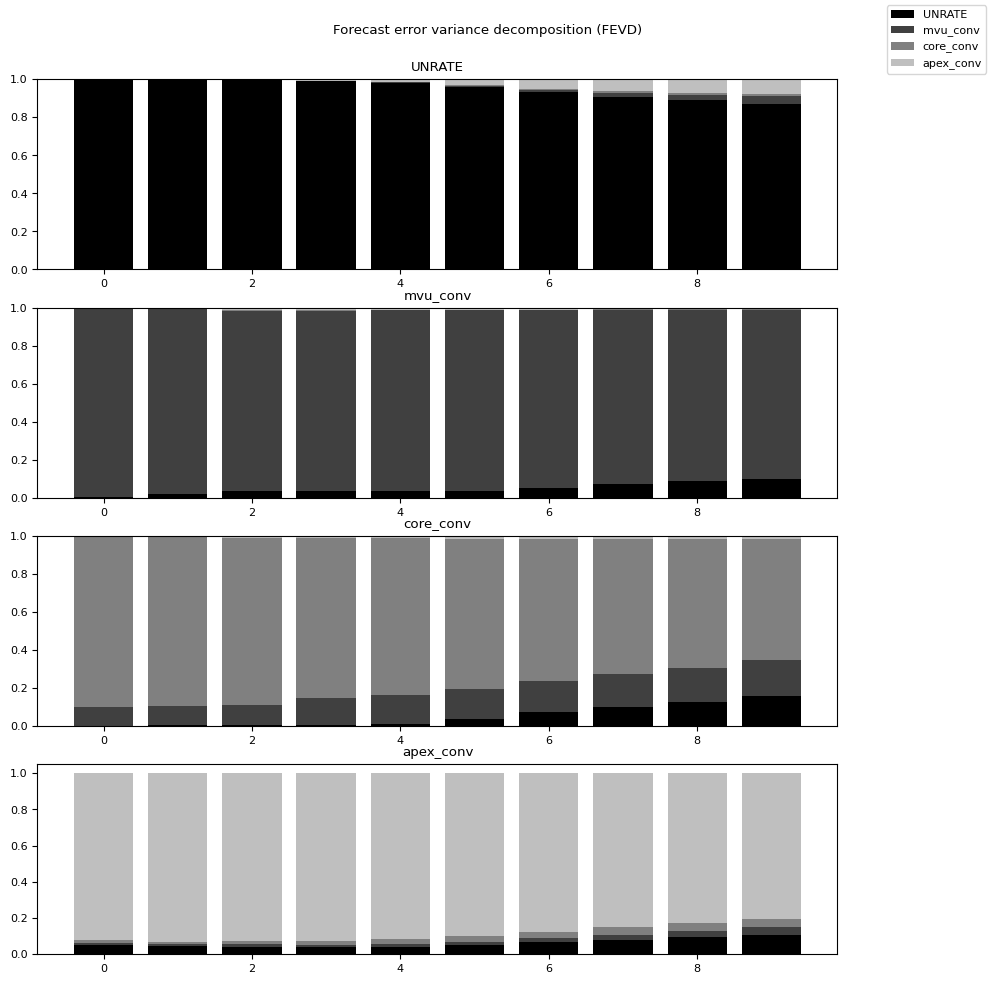

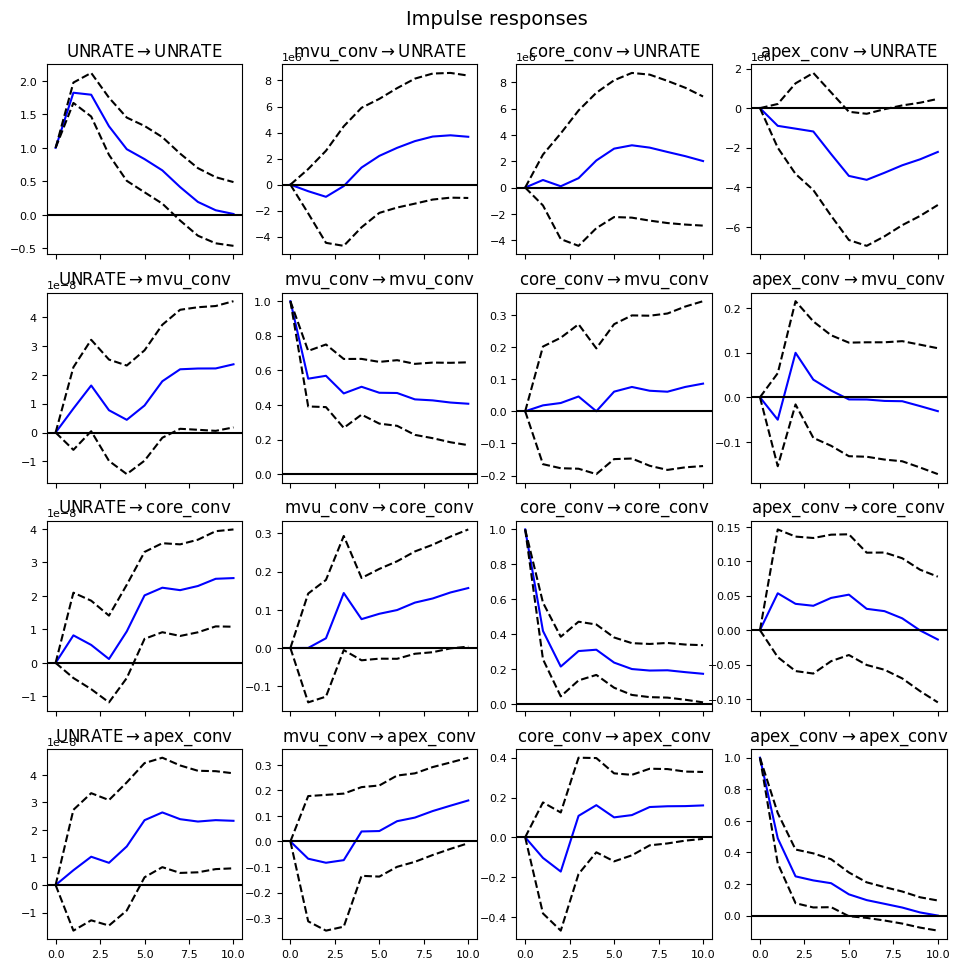

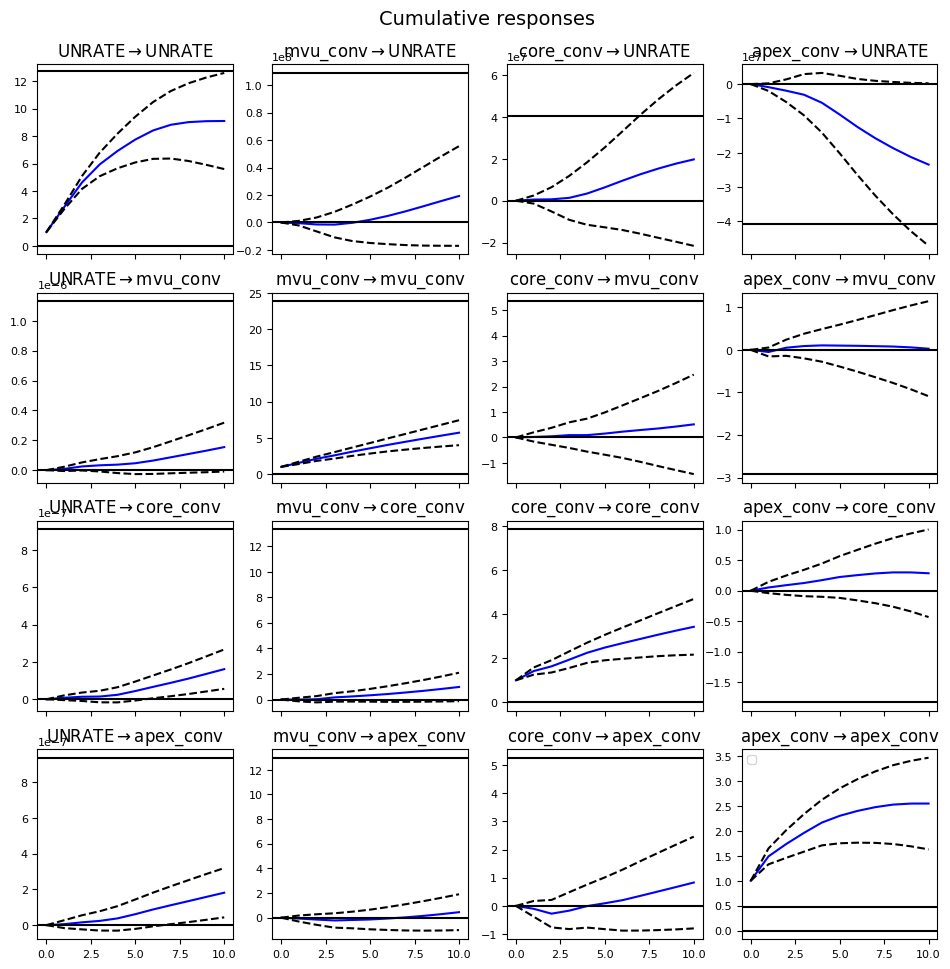


Granger Causality:
Granger causality F-test. H_0: UNRATE does not Granger-cause mvu_conv. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         2.071          2.386   0.083 (4, 648)
----------------------------------------------
Granger causality F-test. H_0: UNRATE does not Granger-cause core_conv. Conclusion: reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         3.120          2.386   0.015 (4, 648)
----------------------------------------------
Granger causality F-test. H_0: UNRATE does not Granger-cause apex_conv. Conclusion: fail to reject H_0 at 5% significance level.
Test statistic Critical value p-value    df   
----------------------------------------------
         1.614          2.386   0.169 (4, 648)
----------------------------------------------

Durban Watson Test for Serial Correla

In [40]:
cols = [cols for cols in df.columns if cols in ['UNRATE','apex_conv','core_conv','mvu_conv']]

mdl = var_craziness(matrix=df[cols].astype(float),lags=4,forecast_prds=6, causing ='UNRATE', caused=[c for c in cols if c != 'UNRATE'])